# Part 1: Single subject classification (subject 2)

In [21]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set() #sets the matplotlib style to seaborn style

from scipy.io import loadmat 
from scipy.ndimage import convolve1d
from scipy.signal import butter
from scipy.signal import sosfiltfilt
from scipy.signal import welch

from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from pathlib import Path
import pandas as pd
from mpl_toolkits.mplot3d import Axes3D
np.random.seed(42)

## Data Loading, preprocessing and visualization

In [22]:
data_path = Path("data/s2/S2_A1_E1.mat")

In [23]:
data = loadmat(data_path)

In [24]:
print("Dataset variables:")
for key in data.keys():
    if not key.startswith("__"):
        print(key)

Dataset variables:
subject
exercise
stimulus
emg
glove
restimulus
repetition
rerepetition


In [25]:
emg_rectified = data["emg"].copy()

#Restimulus and rerepetition are the stimulus and repetition that have been processed for better correspondance to real movement
#Stimulus is the type of movement that is being performed
stimulus = data["restimulus"] 
#Repetition is the number of times the movement has been repeated
repetition = data["rerepetition"] 

print(f'What are the shape of the data that we are working with? \nEMG: {emg_rectified.shape}, \nStimulus {stimulus.shape}, \nRepetition {repetition.shape}')

What are the shape of the data that we are working with? 
EMG: (100686, 10), 
Stimulus (100686, 1), 
Repetition (100686, 1)


In [26]:
# -1 because 0 is the resting condition
n_stimuli = len(np.unique(stimulus)) - 1 
# -1 because 0 is not a repetition
n_repetitions = len(np.unique(repetition)) - 1 
n_channels = emg_rectified.shape[1]

print(f'How many types of movement are there? {n_stimuli}') 
print(f'How many repetitions are there? {n_repetitions}') 

How many types of movement are there? 12
How many repetitions are there? 10


In [27]:
number_of_samples_per_trial = np.zeros((n_stimuli, n_repetitions))

for stimuli_idx in range(n_stimuli):
    for repetition_idx in range(n_repetitions):
        
        idx = np.logical_and(stimulus == stimuli_idx+1, repetition == repetition_idx+1)
        number_of_samples_per_trial[stimuli_idx, repetition_idx] = np.sum(idx.astype(int))

number_of_samples_per_trial

array([[307., 390., 262., 226., 418., 204., 196., 270., 306., 489.],
       [334., 323., 344., 309., 333., 376., 362., 307., 348., 339.],
       [465., 352., 450., 460., 436., 389., 323., 388., 383., 316.],
       [310., 402., 357., 396., 255., 333., 263., 369., 438., 471.],
       [516., 382., 425., 379., 463., 411., 387., 343., 286., 377.],
       [337., 319., 337., 368., 338., 336., 268., 354., 319., 313.],
       [428., 392., 341., 393., 421., 445., 342., 328., 329., 358.],
       [289., 372., 406., 397., 498., 336., 415., 328., 472., 405.],
       [384., 424., 371., 316., 280., 314., 342., 284., 307., 421.],
       [311., 296., 299., 296., 301., 246., 213., 317., 493., 221.],
       [352., 403., 338., 416., 330., 355., 313., 322., 329., 219.],
       [270., 330., 300., 387., 295., 204., 363., 267., 281., 329.]])

In [28]:
#defining the length of the moving average window
mov_mean_length = 25
mov_mean_weights = np.ones(mov_mean_length) / mov_mean_length

#initializing the data structure
emg_windows = [[None for repetition_idx in range(n_repetitions)] for stimuli_idx in range(n_stimuli)]
emg_envelopes = [[None for repetition_idx in range(n_repetitions)] for stimuli_idx in range(n_stimuli)]

for stimuli_idx in range(n_stimuli):
    for repetition_idx in range(n_repetitions):
        idx = np.logical_and(stimulus == stimuli_idx + 1, repetition == repetition_idx + 1).flatten()
        emg_windows[stimuli_idx][repetition_idx] = emg_rectified[idx, :]
        emg_envelopes[stimuli_idx][repetition_idx] = convolve1d(emg_windows[stimuli_idx][repetition_idx], mov_mean_weights, axis=0) 


Text(0.5, 0.98, 'Envelopes of the EMG signal')

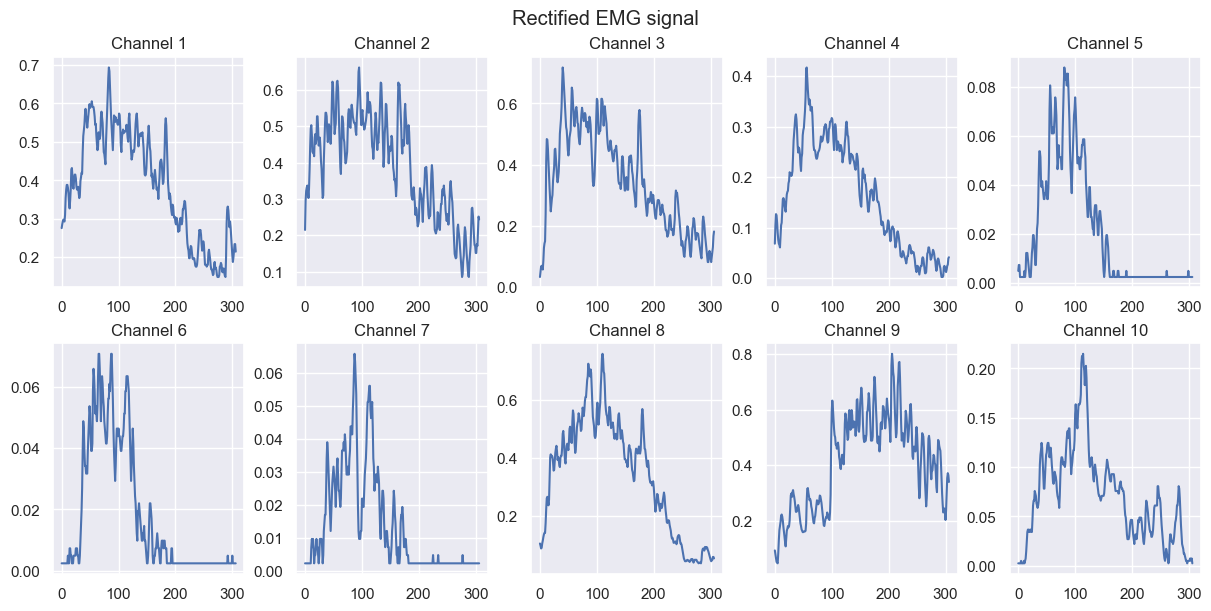

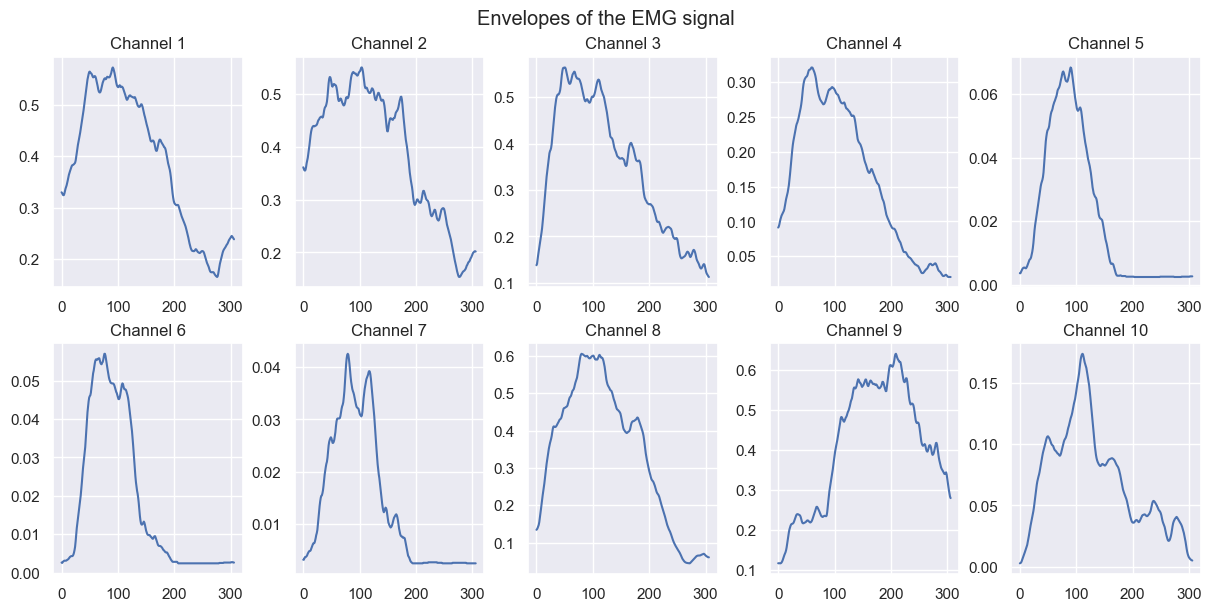

In [29]:
fig, ax = plt.subplots(2, 5, figsize=(12, 6), constrained_layout=True)
ax = ax.ravel()

#10 EMG channels
number_of_emg_channels = emg_rectified.shape[-1]
# plot Rectified EMG signal
for channel_idx in range(number_of_emg_channels): 
    ax[channel_idx].plot(emg_windows[0][0][:, channel_idx])
    ax[channel_idx].set_title(f"Channel {channel_idx+1}")
plt.suptitle("Rectified EMG signal")

# plot Envelopes of the EMG signal
fig, ax = plt.subplots(2, 5, figsize=(12, 6), constrained_layout=True)
ax = ax.ravel()
for channel_idx in range(number_of_emg_channels): 
    ax[channel_idx].plot(emg_envelopes[0][0][:, channel_idx])
    ax[channel_idx].set_title(f"Channel {channel_idx+1}")
plt.suptitle("Envelopes of the EMG signal")

Text(0.5, 0.98, 'Envelopes of the EMG signal')

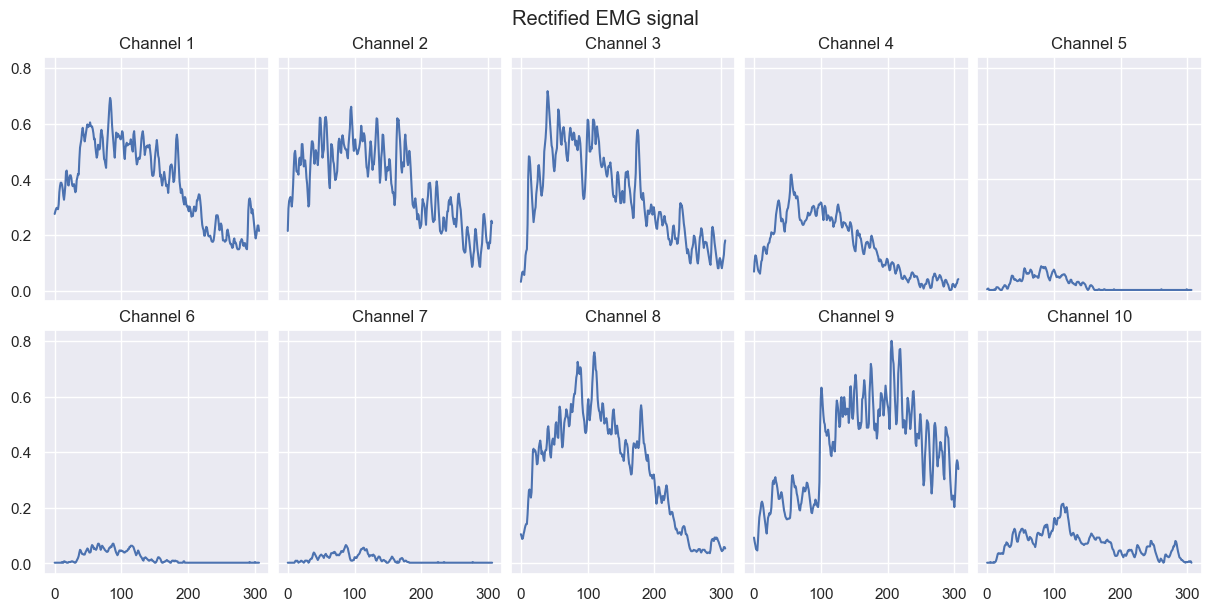

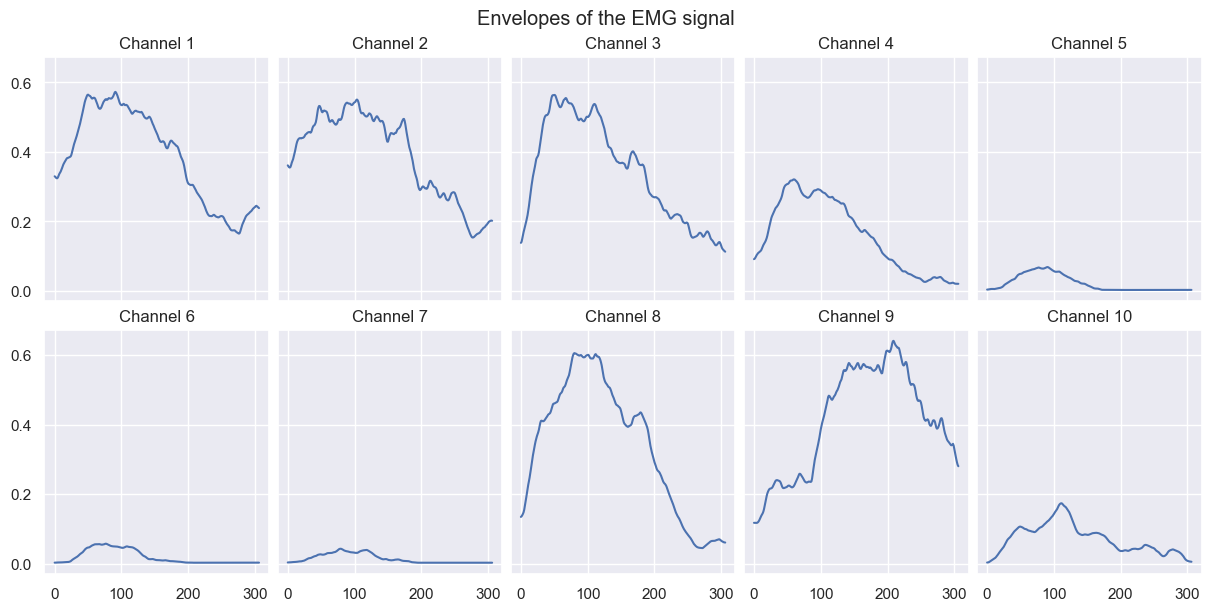

In [30]:
# Now we plot all the channels on the same y-scale
fig, ax = plt.subplots(2, 5, figsize=(12, 6), constrained_layout=True, sharex=True, sharey=True)
ax = ax.ravel()

number_of_emg_channels = emg_rectified.shape[-1]
# plot Rectified EMG signal
for channel_idx in range(number_of_emg_channels): 
    ax[channel_idx].plot(emg_windows[0][0][:, channel_idx])
    ax[channel_idx].set_title(f"Channel {channel_idx+1}")
plt.suptitle("Rectified EMG signal")

# plot Envelopes of the EMG signal
fig, ax = plt.subplots(2, 5, figsize=(12, 6), constrained_layout=True, sharex=True, sharey=True)
ax = ax.ravel()
for channel_idx in range(number_of_emg_channels): 
    ax[channel_idx].plot(emg_envelopes[0][0][:, channel_idx])
    ax[channel_idx].set_title(f"Channel {channel_idx+1}")
plt.suptitle("Envelopes of the EMG signal")

In [31]:
emg_average_activations = np.zeros((n_channels, n_stimuli, n_repetitions))
for stimuli_idx in range(n_stimuli):
    for repetition_idx in range(n_repetitions):
        #mean across time for each channel
        emg_average_activations[:, stimuli_idx, repetition_idx] = np.mean(emg_envelopes[stimuli_idx][repetition_idx], axis=0) 

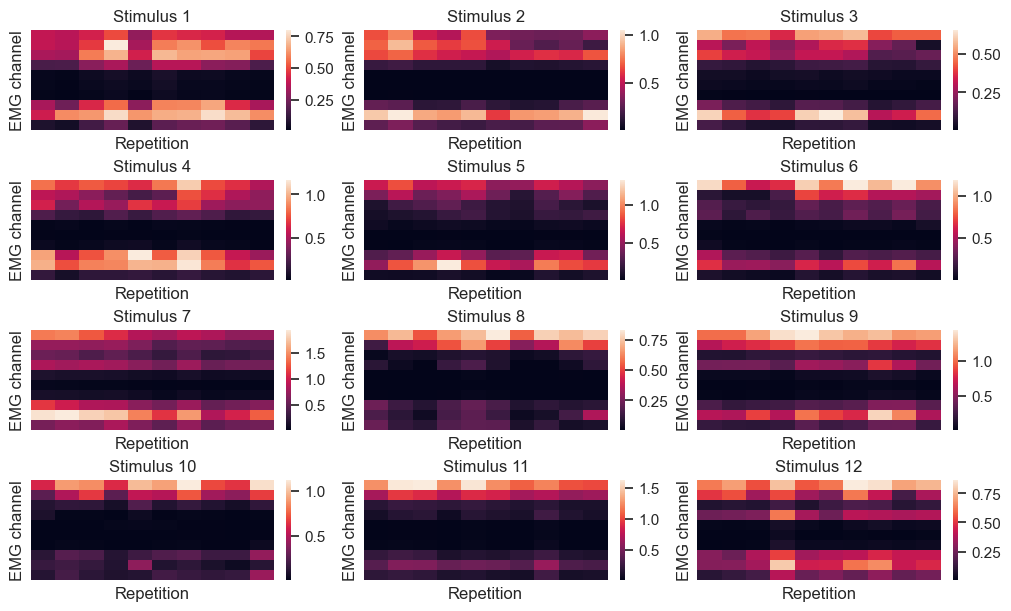

In [32]:
fig, ax = plt.subplots(4, 3, figsize=(10, 6), constrained_layout=True, sharex=True, sharey=True)
ax = ax.ravel()

for stimuli_idx in range(n_stimuli):
    sns.heatmap(np.squeeze(emg_average_activations[:, stimuli_idx, :]), ax=ax[stimuli_idx] ,xticklabels=False, yticklabels=False, cbar = True)
    ax[stimuli_idx].title.set_text("Stimulus " + str(stimuli_idx + 1))
    ax[stimuli_idx].set_xlabel("Repetition")
    ax[stimuli_idx].set_ylabel("EMG channel")

## Data split

In [33]:
def build_dataset_from_ninapro(emg, stimulus, repetition, features=None):
    # Calculate the number of unique stimuli and repetitions, subtracting 1 to exclude the resting condition
    n_stimuli = np.unique(stimulus).size - 1
    n_repetitions = np.unique(repetition).size - 1
    # Total number of samples is the product of stimuli and repetitions
    n_samples = n_stimuli * n_repetitions
    
    # Number of channels in the EMG data
    n_channels = emg.shape[1]
    # Calculate the total number of features by summing the number of channels for each feature
    n_features = sum(n_channels for feature in features)
    
    # Initialize the dataset and labels arrays with zeros
    dataset = np.zeros((n_samples, n_features))
    labels = np.zeros(n_samples)
    current_sample_index = 0
    
    # Loop over each stimulus and repetition to extract features
    for i in range(n_stimuli):
        for j in range(n_repetitions):
            # Assign the label for the current sample
            labels[current_sample_index] = i + 1
            # Calculate the current sample index based on stimulus and repetition
            current_sample_index = i * n_repetitions + j
            current_feature_index = 0
            # Select the time steps corresponding to the current stimulus and repetition
            selected_tsteps = np.logical_and(stimulus == i + 1, repetition == j + 1).squeeze()
            
            # Loop over each feature function provided
            for feature in features:
                # Determine the indices in the dataset where the current feature will be stored
                selected_features = np.arange(current_feature_index, current_feature_index + n_channels)
                # Apply the feature function to the selected EMG data and store the result
                dataset[current_sample_index, selected_features] = feature(emg[selected_tsteps, :])
                # Update the feature index for the next feature
                current_feature_index += n_channels

            # Move to the next sample
            current_sample_index += 1
            
    # Return the constructed dataset and corresponding labels
    return dataset, labels

## Feature extraction

In [34]:
# Mean absolute value (MAV)
mav = lambda x: np.mean(np.abs(x), axis=0)

# Standard Deviation (STD)
std = lambda x: np.std(x, axis=0)

# Maximum absolute Value (MaxAV)
maxav = lambda x: np.max(np.abs(x), axis=0)

# Root mean square (RMS)
rms = lambda x: np.sqrt(np.mean(x**2, axis=0))

# Waveform length (WL)
# Sum of absolute differences between consecutive samples
wl = lambda x: np.sum(np.abs(np.diff(x, axis=0)), axis=0)

# Slope sign changes (SSC)
# Counts how often the slope changes sign (per channel)
def ssc(x, eps=1e-6):
    # x: (T, C)
    # diff1: x[n] - x[n-1], diff2: x[n] - x[n+1] for n=1..T-2
    diff1 = x[1:-1, :] - x[:-2, :]
    diff2 = x[1:-1, :] - x[2:, :]
    # sign change where product < 0 (and optionally above a tiny threshold)
    return np.sum((diff1 * diff2 < -eps).astype(int), axis=0)

features = [mav, std, maxav, rms, wl, ssc]

dataset, labels = build_dataset_from_ninapro(
    emg=emg_rectified ,
    stimulus=stimulus,
    repetition=repetition,
    features=features  # or [mav, std] if you're starting simple
)

print(f"dataset dimension: {dataset.shape}")
print(f"labels dimension: {labels.shape}")


dataset dimension: (120, 60)
labels dimension: (120,)


## Data splitting

In [35]:
X_train, X_test, y_train, y_test = train_test_split(dataset, labels, test_size=0.3, random_state=0)

**Why do we need different datasets?**

We split the data into three subsets because each one plays an essential role:

- **Training set** : Used to train the model and learn the underlying patterns in the data.

- **Validation set** : Used to tune hyperparameters and select the best model configuration.  
  The model is not trained on this data, which helps prevent overfitting.

- **Test set** : Used only at the end to evaluate how well the final model performs on completely unseen data.


## Model fitting

Accuracy score: 0.7222222222222222


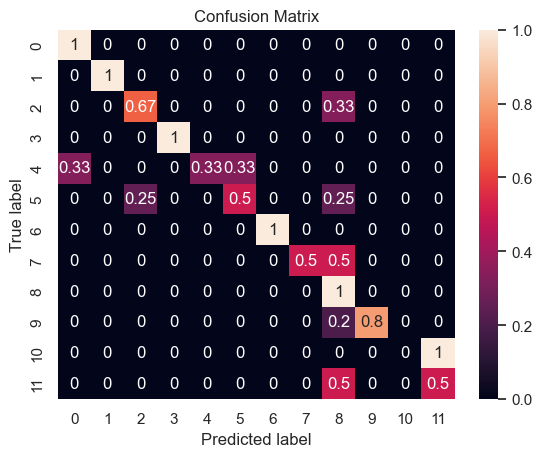

In [36]:

# Normalizing the data (not required for trees, but OK to keep)
scaler = StandardScaler()
X_train_z = scaler.fit_transform(X_train)
X_test_z = scaler.transform(X_test)

# Train a Gradient Boosting classifier on the normalized data
clf = GradientBoostingClassifier(
    n_estimators=100,      # number of trees
    learning_rate=0.1,    # step size
    max_depth=3,          # depth of individual trees
    random_state=0
)
clf.fit(X_train_z, y_train)

# Evaluate the classifier on the test set
y_pred = clf.predict(X_test_z)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy score: {accuracy}")

# Confusion matrix
confmat = confusion_matrix(y_test, y_pred, normalize="true")
fig, ax = plt.subplots()
sns.heatmap(confmat, annot=True, ax=ax)
plt.title("Confusion Matrix")
ax.set_ylabel("True label")
ax.set_xlabel("Predicted label");


In [37]:
scores = cross_val_score(clf, X_train_z, y_train, cv=5)
print(f"Accuracy scores of all models: {scores}")
print(f"Mean accuracy across all models: {np.mean(scores)}")

Accuracy scores of all models: [0.76470588 0.64705882 0.76470588 0.52941176 0.5625    ]
Mean accuracy across all models: 0.6536764705882352


## Hyperparameter optimization

In [38]:
# use cross validation to find the best hyperparameters for GradientBoostingClassifier

param_grid = {
    "n_estimators": [50, 100, 200],      # number of trees
    "learning_rate": [0.01, 0.05, 0.1],  # step size
    "max_depth": [2, 3, 4],              # depth of individual trees
    "subsample": [0.6, 0.8],        # fraction of samples per tree
}

grid = GridSearchCV(
    GradientBoostingClassifier(random_state=42),
    param_grid=param_grid,
    cv=5,                # 5-fold cross-validation
    scoring="accuracy",
    verbose = 2,
)

grid.fit(X_train_z, y_train)
best_model = grid.best_estimator_
print(f"Best estimator: {best_model}")
print(f"Best hyperparameters: {grid.best_params_}")


Fitting 5 folds for each of 54 candidates, totalling 270 fits
[CV] END learning_rate=0.01, max_depth=2, n_estimators=50, subsample=0.6; total time=   0.3s
[CV] END learning_rate=0.01, max_depth=2, n_estimators=50, subsample=0.6; total time=   0.3s
[CV] END learning_rate=0.01, max_depth=2, n_estimators=50, subsample=0.6; total time=   0.3s
[CV] END learning_rate=0.01, max_depth=2, n_estimators=50, subsample=0.6; total time=   0.3s
[CV] END learning_rate=0.01, max_depth=2, n_estimators=50, subsample=0.6; total time=   0.3s
[CV] END learning_rate=0.01, max_depth=2, n_estimators=50, subsample=0.8; total time=   0.3s
[CV] END learning_rate=0.01, max_depth=2, n_estimators=50, subsample=0.8; total time=   0.3s
[CV] END learning_rate=0.01, max_depth=2, n_estimators=50, subsample=0.8; total time=   0.3s
[CV] END learning_rate=0.01, max_depth=2, n_estimators=50, subsample=0.8; total time=   0.4s
[CV] END learning_rate=0.01, max_depth=2, n_estimators=50, subsample=0.8; total time=   0.4s
[CV] END

## Model evaluation

In [39]:
y_pred = best_model.predict(X_test_z)

accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy score of best model: {accuracy}")

Accuracy score of best model: 0.8888888888888888


We evaluated the classifier using accuracy, which is suitable because the dataset contains balanced classes and the goal is to maximize correct gesture classification. Our best model achieved an accuracy of 88%, which is consistent with expected performance for EMG recognition using classical time-domain features. This performance is satisfactory for this stage of the project, although further improvements could be obtained by adding more advanced features or using more powerful models.

## 6. Feature Selection / Dimension Selection 

we'll use : 
1. ANOVA F-test

2. Mutual Information

using sklearn SelectKbest

### 1. ANOVA F-test (sklearn SelectKBest) 

In [40]:
pipe_kbest = Pipeline([
    ("scaler", StandardScaler()),
    ("select", SelectKBest(score_func=f_classif)),
    ("clf", best_model),
])
param_grid = {
    "select__k": [10, 20, 30, 40 , 50 , "all"], # having 50 features overall
}

grid_kbest = GridSearchCV(
    pipe_kbest,
    param_grid=param_grid,
    cv=5,
    scoring="accuracy",
    verbose = 2,
)

grid_kbest.fit(X_train, y_train)

print("Best params:", grid_kbest.best_params_)
print("Best CV accuracy:", grid_kbest.best_score_)

Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV] END .......................................select__k=10; total time=   0.2s
[CV] END .......................................select__k=10; total time=   0.2s
[CV] END .......................................select__k=10; total time=   0.2s
[CV] END .......................................select__k=10; total time=   0.2s
[CV] END .......................................select__k=10; total time=   0.2s
[CV] END .......................................select__k=20; total time=   0.3s
[CV] END .......................................select__k=20; total time=   0.3s
[CV] END .......................................select__k=20; total time=   0.3s
[CV] END .......................................select__k=20; total time=   0.3s
[CV] END .......................................select__k=20; total time=   0.3s
[CV] END .......................................select__k=30; total time=   0.3s
[CV] END .......................................s

Accuracy score of a model with k = 40 best features: 0.8888888888888888


Text(0.5, 1.0, 'Confusion Matrix')

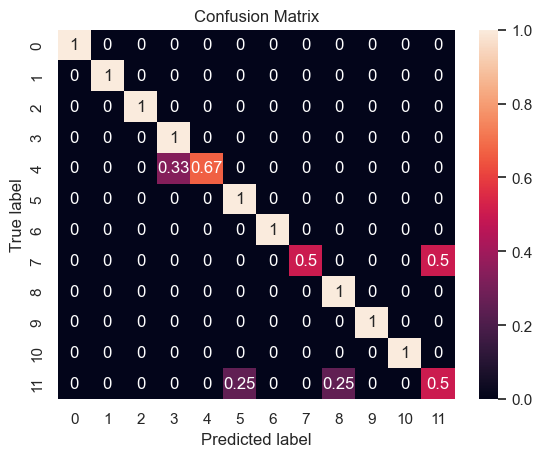

In [41]:
best_anova=grid_kbest.best_estimator_
best_select = best_anova.named_steps["select"]
mask = best_select.get_support() # boolean mask of selected features

y_pred_ANOVA = best_anova.predict(X_test)

# Calculate the accuracy of the model with the selected features.
acc_ANOVA = accuracy_score(y_test, y_pred_ANOVA)
print(f"Accuracy score of a model with k = {best_select.k} best features: {acc_ANOVA}")

# The confusion matrix shows the true vs predicted labels.
confmat = confusion_matrix(y_test, y_pred_ANOVA, normalize="true")

fig, ax = plt.subplots()
sns.heatmap(confmat, annot=True, ax=ax)
ax.set_ylabel("True label")
ax.set_xlabel("Predicted label")
plt.title("Confusion Matrix")

Finding which features were selected 

In [42]:
feature_types = ["MAV", "STD", "RMS", "maxav", "WL", "SSC"]  
n_channels = 10
n_feat_per_channel = 6
feature_names = []
for ch in range(n_channels):
    for ftype in feature_types:
        feature_names.append(f"ch{ch+1}_{ftype}")

In [43]:
mask_matrix = mask.reshape(n_channels, n_feat_per_channel)

for ch in range(n_channels):
    selected_feats = [
        feature_types[j]
        for j, keep in enumerate(mask_matrix[ch])
        if keep
    ]
    
    if selected_feats:
        print(f"Channel {ch+1}: {selected_feats}")
    else:
        print(f"Channel {ch+1}: None")

Channel 1: ['MAV', 'RMS', 'maxav', 'WL']
Channel 2: ['MAV', 'STD', 'RMS', 'maxav', 'WL']
Channel 3: ['MAV', 'STD', 'RMS', 'maxav', 'SSC']
Channel 4: ['STD', 'RMS', 'WL', 'SSC']
Channel 5: ['maxav', 'SSC']
Channel 6: ['MAV', 'RMS', 'maxav', 'WL', 'SSC']
Channel 7: ['MAV', 'STD', 'RMS', 'maxav']
Channel 8: ['MAV', 'STD', 'RMS', 'maxav', 'WL', 'SSC']
Channel 9: ['MAV', 'STD']
Channel 10: ['MAV', 'STD', 'RMS']


### 2. Mutual Information (MI)

In [44]:
pipe_mi = Pipeline([
    ("scaler", StandardScaler()),
    ("select", SelectKBest(score_func=mutual_info_classif)),  # MI instead of f_classif
    ("clf", GradientBoostingClassifier(random_state=0)),
])
param_grid_mi = {
    "select__k": [10, 20, 30, 40, "all"],
    "clf__n_estimators": [50, 100, 150],
    "clf__learning_rate": [0.01, 0.05, 0.1],
    "clf__max_depth": [2, 3],
    "clf__subsample": [0.6, 0.8],
}

grid_mi = GridSearchCV(
    pipe_mi,
    param_grid=param_grid_mi,
    cv=5,
    scoring="accuracy",
    verbose=2,
    n_jobs=-1,
)

grid_mi.fit(X_train, y_train)

print("Best MI params:", grid_mi.best_params_)
print("Best CV accuracy (MI):", grid_mi.best_score_)

Fitting 5 folds for each of 180 candidates, totalling 900 fits
[CV] END clf__learning_rate=0.01, clf__max_depth=2, clf__n_estimators=50, clf__subsample=0.6, select__k=10; total time=   1.1s
[CV] END clf__learning_rate=0.01, clf__max_depth=2, clf__n_estimators=50, clf__subsample=0.6, select__k=10; total time=   1.1s
[CV] END clf__learning_rate=0.01, clf__max_depth=2, clf__n_estimators=50, clf__subsample=0.6, select__k=10; total time=   1.2s
[CV] END clf__learning_rate=0.01, clf__max_depth=2, clf__n_estimators=50, clf__subsample=0.6, select__k=10; total time=   1.2s
[CV] END clf__learning_rate=0.01, clf__max_depth=2, clf__n_estimators=50, clf__subsample=0.6, select__k=20; total time=   1.2s
[CV] END clf__learning_rate=0.01, clf__max_depth=2, clf__n_estimators=50, clf__subsample=0.6, select__k=20; total time=   1.2s
[CV] END clf__learning_rate=0.01, clf__max_depth=2, clf__n_estimators=50, clf__subsample=0.6, select__k=10; total time=   1.2s
[CV] END clf__learning_rate=0.01, clf__max_depth

Accuracy score of MI model with k = 40 best features: 0.8611111111111112


Text(0.5, 1.0, 'Confusion Matrix')

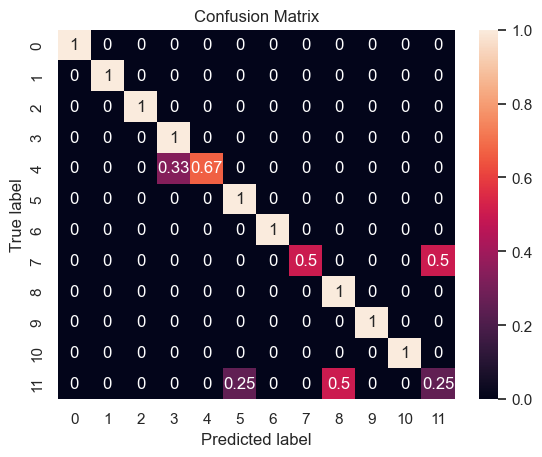

In [45]:
best_mi_model = grid_mi.best_estimator_
selector_mi = best_mi_model.named_steps["select"]
mask_mi = selector_mi.get_support()

y_pred_MI= best_mi_model.predict(X_test)


# Calculate the accuracy of the model with the selected features.
acc_MI = accuracy_score(y_test, y_pred_MI)
print(f"Accuracy score of MI model with k = {selector_mi.k} best features: {acc_MI}")

# The confusion matrix shows the true vs predicted labels.
confmat = confusion_matrix(y_test, y_pred_MI, normalize="true")

fig, ax = plt.subplots()
sns.heatmap(confmat, annot=True, ax=ax)
ax.set_ylabel("True label")
ax.set_xlabel("Predicted label")
plt.title("Confusion Matrix")

In [46]:

# Per-channel view
mask_matrix_mi = mask_mi.reshape(n_channels, n_feat_per_channel)

for ch in range(n_channels):
    selected_feats = [
        feature_types[j]
        for j, keep in enumerate(mask_matrix_mi[ch])
        if keep
    ]
    if selected_feats:
        print(f"Channel {ch+1}: {selected_feats}")
    else:
        print(f"Channel {ch+1}: None")


Channel 1: ['MAV', 'RMS', 'maxav', 'WL']
Channel 2: ['STD', 'RMS', 'maxav', 'WL']
Channel 3: ['MAV', 'STD', 'RMS', 'WL', 'SSC']
Channel 4: ['MAV', 'RMS', 'WL', 'SSC']
Channel 5: ['MAV', 'RMS', 'maxav', 'WL']
Channel 6: ['MAV', 'RMS', 'maxav', 'WL']
Channel 7: ['MAV', 'STD', 'RMS', 'maxav']
Channel 8: ['MAV', 'STD', 'RMS', 'maxav', 'WL', 'SSC']
Channel 9: ['MAV', 'STD']
Channel 10: ['MAV', 'STD', 'RMS']


## Dimension reduction 

### 1. Principal component analysis (PCA)


In [47]:
param_grid_pca = Pipeline([
    ("scaler", StandardScaler()),
    ("pca", PCA()),
    ("clf", GradientBoostingClassifier(random_state=0)),
])

param_grid_lda = {
    "pca__n_components": [10, 15, 20, 30, 40, 50],
    "clf__n_estimators": [50, 100, 150],
    "clf__learning_rate": [0.01, 0.05, 0.1],
    "clf__max_depth": [2, 3],
    "clf__subsample": [0.6, 0.8],
}

grid_pca = GridSearchCV(
    param_grid_pca,
    param_grid=param_grid_lda,
    cv=5,
    scoring="accuracy",
    verbose=2,
)
grid_pca.fit(X_train, y_train)

print("Best PCA params:", grid_pca.best_params_)
print("Best CV accuracy (PCA):", grid_pca.best_score_)

Fitting 5 folds for each of 216 candidates, totalling 1080 fits
[CV] END clf__learning_rate=0.01, clf__max_depth=2, clf__n_estimators=50, clf__subsample=0.6, pca__n_components=10; total time=   0.3s
[CV] END clf__learning_rate=0.01, clf__max_depth=2, clf__n_estimators=50, clf__subsample=0.6, pca__n_components=10; total time=   0.3s
[CV] END clf__learning_rate=0.01, clf__max_depth=2, clf__n_estimators=50, clf__subsample=0.6, pca__n_components=10; total time=   0.3s
[CV] END clf__learning_rate=0.01, clf__max_depth=2, clf__n_estimators=50, clf__subsample=0.6, pca__n_components=10; total time=   0.3s
[CV] END clf__learning_rate=0.01, clf__max_depth=2, clf__n_estimators=50, clf__subsample=0.6, pca__n_components=10; total time=   0.3s
[CV] END clf__learning_rate=0.01, clf__max_depth=2, clf__n_estimators=50, clf__subsample=0.6, pca__n_components=15; total time=   0.3s
[CV] END clf__learning_rate=0.01, clf__max_depth=2, clf__n_estimators=50, clf__subsample=0.6, pca__n_components=15; total time

In [48]:
pca = grid_pca.best_estimator_.named_steps["pca"]
var = pca.explained_variance_ratio_
scaler = StandardScaler()
X_scaled = scaler.fit_transform(dataset)
X_pca = pca.transform(X_scaled)
print("Number of PCA components:", pca.n_components_)

Number of PCA components: 15


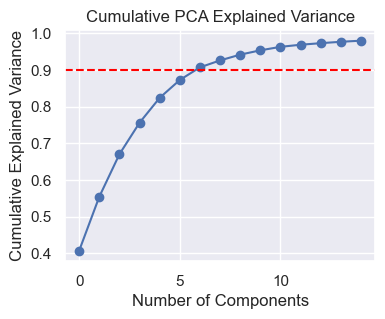

In [49]:
plt.figure(figsize=(4,3))
plt.plot(np.cumsum(var), marker='o')
plt.axhline(0.9, color='red', linestyle='--')  # 90% reference line
plt.xlabel("Number of Components")
plt.ylabel("Cumulative Explained Variance")
plt.title("Cumulative PCA Explained Variance")
plt.grid(True)
plt.show()

Test accuracy of the PCA model using 15 principal components: 0.583


Text(0.5, 1.0, 'Confusion Matrix')

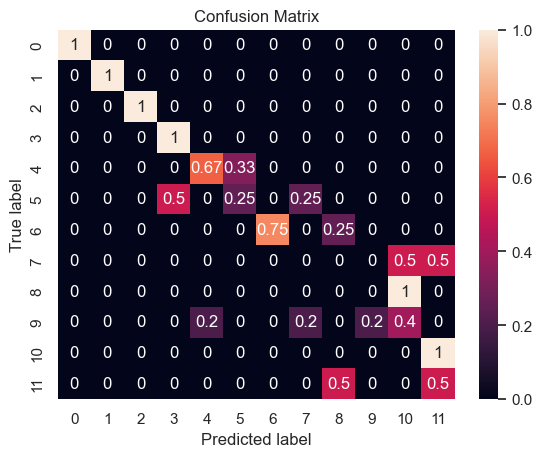

In [50]:
best_PCA_model = grid_pca.best_estimator_
y_pred_PCA= best_PCA_model.predict(X_test)

# Calculate the accuracy of the model with the selected features.
acc_PCA = accuracy_score(y_test, y_pred_PCA)
print(f"Test accuracy of the PCA model using {pca.n_components_} principal components: {acc_PCA:.3f}")


# The confusion matrix shows the true vs predicted labels.
confmat = confusion_matrix(y_test, y_pred_PCA, normalize="true")

fig, ax = plt.subplots()
sns.heatmap(confmat, annot=True, ax=ax)
ax.set_ylabel("True label")
ax.set_xlabel("Predicted label")
plt.title("Confusion Matrix")

### 2. Linear Discriminant Analysis (LDA)

In [51]:
pipe_lda = Pipeline([
    ("scaler", StandardScaler()),
    ("lda", LDA()),
    ("clf", GradientBoostingClassifier(random_state=0)),
])

param_grid_lda = {
    "clf__n_estimators": [50, 100, 150],
    "clf__learning_rate": [0.01, 0.05, 0.1],
    "clf__max_depth": [2, 3],
    "clf__subsample": [0.6, 0.8],
}

grid_lda = GridSearchCV(
    pipe_lda,
    param_grid=param_grid_lda,
    cv=5,
    scoring="accuracy",
    verbose=2,
)
grid_lda.fit(X_train, y_train)

print("Best LDA params:", grid_lda.best_params_)
print("Best CV accuracy (LDA):", grid_lda.best_score_)


Fitting 5 folds for each of 36 candidates, totalling 180 fits


[CV] END clf__learning_rate=0.01, clf__max_depth=2, clf__n_estimators=50, clf__subsample=0.6; total time=   0.4s
[CV] END clf__learning_rate=0.01, clf__max_depth=2, clf__n_estimators=50, clf__subsample=0.6; total time=   0.5s
[CV] END clf__learning_rate=0.01, clf__max_depth=2, clf__n_estimators=50, clf__subsample=0.6; total time=   0.4s
[CV] END clf__learning_rate=0.01, clf__max_depth=2, clf__n_estimators=50, clf__subsample=0.6; total time=   0.4s
[CV] END clf__learning_rate=0.01, clf__max_depth=2, clf__n_estimators=50, clf__subsample=0.6; total time=   0.4s
[CV] END clf__learning_rate=0.01, clf__max_depth=2, clf__n_estimators=50, clf__subsample=0.8; total time=   0.3s
[CV] END clf__learning_rate=0.01, clf__max_depth=2, clf__n_estimators=50, clf__subsample=0.8; total time=   0.3s
[CV] END clf__learning_rate=0.01, clf__max_depth=2, clf__n_estimators=50, clf__subsample=0.8; total time=   0.4s
[CV] END clf__learning_rate=0.01, clf__max_depth=2, clf__n_estimators=50, clf__subsample=0.8; to

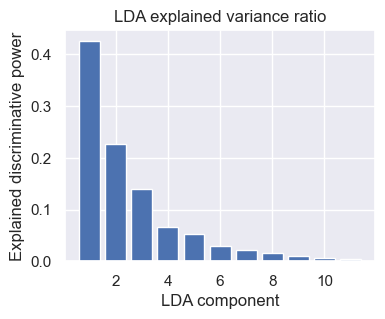

In [52]:
lda = grid_lda.best_estimator_.named_steps["lda"]
evr = lda.explained_variance_ratio_ 

plt.figure(figsize=(4,3))
plt.bar(range(1, len(evr)+1), evr)
plt.xlabel("LDA component")
plt.ylabel("Explained discriminative power")
plt.title("LDA explained variance ratio")
plt.show()

Test accuracy of the LDA model : 0.417


Text(0.5, 1.0, 'Confusion Matrix')

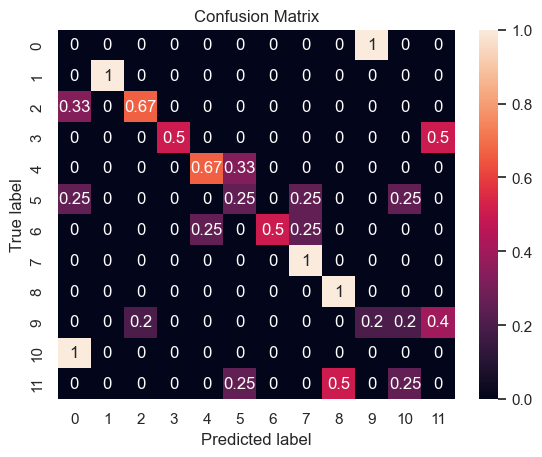

In [53]:
best_LDA_model = grid_lda.best_estimator_
y_pred_lda =best_LDA_model.predict(X_test)
acc_LDA = accuracy_score(y_test, y_pred_lda)

print(f"Test accuracy of the LDA model : {acc_LDA:.3f}")

# The confusion matrix shows the true vs predicted labels.
confmat = confusion_matrix(y_test, y_pred_lda, normalize="true")

fig, ax = plt.subplots()
sns.heatmap(confmat, annot=True, ax=ax)
ax.set_ylabel("True label")
ax.set_xlabel("Predicted label")
plt.title("Confusion Matrix")

### Comparing accuracies across the different approaches 

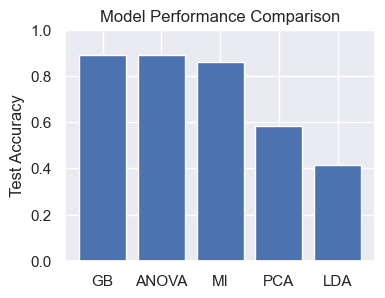

In [54]:
accuracies = {
    "GB": accuracy,
    "ANOVA": acc_ANOVA,
    "MI": acc_MI,
    "PCA": acc_PCA,
    "LDA": acc_LDA
}

plt.figure(figsize=(4,3))
plt.bar(accuracies.keys(), accuracies.values())
plt.ylabel("Test Accuracy")
plt.ylim(0, 1)
plt.title("Model Performance Comparison")
plt.show()
